In [1]:
%load_ext autoreload
%autoreload 2

import glob
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sys
sys.path.append('../../plume_dynamic_analyzer/src/')
from analyzer.plume_utils import remove_all_0_plume
from analyzer.PlumeDataset import plume_dataset

sys.path.append('../../py-utils/src/')
from viz import show_images, label_violinplot

## 100 mTorr, 1.6 J/cm^2 for multiple growth

Analyze plume: Seperate the plume into several stages: surface ablation, plume transport, plume landing.

### example plumes

In [ ]:
file = 'D:/pld_plumes/SRO_STO_Drexel/YG063_YichenGuo_08042024.h5'
plume_ds = plume_dataset(file_path=file, group_name='PLD_Plumes')
keys = plume_ds.dataset_names()
print(keys)
plumes = plume_ds.load_plumes('1-SrRuO3')
print(plumes.shape)

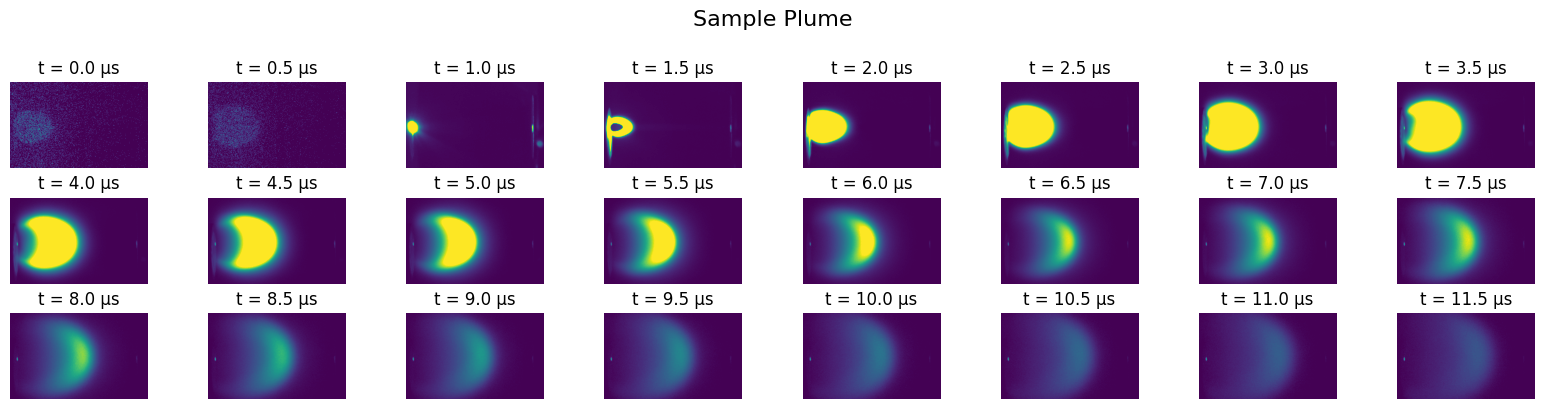

In [43]:
sample_frames = plumes[0][:24]
labels = np.arange(len(plumes[0][:24]))*500e-3
labels = [f't = {l:.1f} µs' for l in labels]
show_images(sample_frames, labels=labels, img_per_row=8, title='Sample Plume')

### load plume data

In [3]:
df_condition = pd.read_excel('../../data/Sample log.xlsx', sheet_name='SRO')
df_condition = df_condition.loc[[27, 34, 35, 36, 37, 38, 39, 40], ['Growth', 'Pressure (mTorr)', 'Temperature (C)', 'Fluence (J/cm2)', 'Repetation rate (Hz)']]
df_condition.replace('700 (heater O)', 700, inplace=True)
df_condition.replace('650 (heater O)', 650, inplace=True)
df_condition.replace('700 (heater N)', 700, inplace=True)
df_condition['Growth'] = df_condition['Growth'].str.replace(r'LYW_YCG', 'YG', regex=True)
df_condition.sample(5)

,Growth,Pressure (mTorr),Temperature (C),Fluence (J/cm2),Repetation rate (Hz)
35,YG064,100.0,700,1.6,5.0
38,YG067,100.0,700,1.6,5.0
34,YG063,100.0,700,1.6,5.0
40,YG069,100.0,700,1.6,6.6
36,YG065,100.0,700,1.6,5.0


### load frame level metrics

In [4]:
growth_names = ['YG065', 'YG066', 'YG067', 'YG068', 'YG069']

In [5]:
df_frame_metrics = []
for key in df_condition['Growth'].unique():
    file = glob.glob(f'../../large_files/SRO_plume_metrics/{key}*metrics.csv')[0]
    # print(file)
    df = pd.read_csv(file, index_col=0)
    df['Threshold'].astype(str)
    df = df[df['Threshold']=='200']
    df = remove_all_0_plume(df.reset_index(), metric='Area', viz=False)
    df_frame_metrics.append(df)
    
df_frame_metrics = pd.concat(df_frame_metrics, ignore_index=True)
df_frame_metrics['time_index'] = df_frame_metrics['time_index'] * 500e-3 # convert ns to ms
df_frame_metrics.rename(columns={'time_index': 'Time (µs)'}, inplace=True)
df_frame_metrics.rename(columns={'plume_index': 'Plume Index'}, inplace=True)

df_frame_metrics_target = df_frame_metrics[df_frame_metrics['Growth'].isin(growth_names)]
df_frame_metrics_target.sample(5)

,Plume Index,Time (µs),Distance,Velocity,Area,Threshold,Growth
275739,48,13.5,209,0.0,0.0,200,YG068
273825,33,16.5,207,0.0,0.0,200,YG068
165783,334,11.5,205,0.0,0.0,200,YG065
245508,187,2.0,153,48000000.0,11930.0,200,YG067
153939,240,41.5,223,0.0,0.0,200,YG065


### calculate plume level metrics

In [6]:
# analyze the max area
# df_frame_metrics_selected = df_frame_metrics[df_frame_metrics['Threshold']=='flexible']
idx = df_frame_metrics.groupby(['Growth', 'Plume Index'])['Area'].idxmax()
df_max_area = df_frame_metrics.loc[idx, ['Growth', 'Plume Index', 'Time (µs)', 'Area']].reset_index(drop=True)
df_max_area.rename(columns={'Area': 'Max Area'}, inplace=True)
df_max_area.rename(columns={'Time (µs)': 'Time at Max Area (µs)'}, inplace=True)
# df_max_area.sample(8)

# analyze plume velocity that can be tracked before landing on the substrate
df_filtered = df_frame_metrics[(df_frame_metrics['Distance'] >= 150) & (df_frame_metrics['Distance'] <= 180)]
df_unique = df_filtered.drop_duplicates(subset=['Time (µs)', 'Distance', 'Velocity', 'Area', 'Threshold'])
incident_velocity = df_unique.groupby(['Growth', 'Plume Index'])['Velocity'].mean().reset_index()
incident_velocity.rename(columns={'Velocity': 'incident_velocity'}, inplace=True)
# incident_velocity.sample(8)

df_plume_metrics = pd.merge(df_max_area, incident_velocity, on=['Growth', 'Plume Index'])
# df_plume_metrics.sample(8)

df_plume_metrics_target = df_plume_metrics[df_plume_metrics['Growth'].isin(growth_names)]
df_plume_metrics_target.sample(5)

,Growth,Plume Index,Time at Max Area (µs),Max Area,incident_velocity
2220,YG068,128,3.0,15584.0,43000000.0
1339,YG065,383,3.0,15411.0,41000000.0
1164,YG065,204,3.0,15496.0,42000000.0
1087,YG065,125,3.0,18644.0,45000000.0
2011,YG067,290,3.0,15463.0,45000000.0


## viz plume_level metrics

In [7]:
colors = sns.color_palette("viridis", as_cmap=False, n_colors=df_plume_metrics_target['Growth'].nunique()) # viridis

### Stability

#### plume max area

C:\Users\yig319\AppData\Local\Temp\ipykernel_42508\1205450893.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Growth', y='Max Area', data=df_plume_metrics_target, width=0.9, ax=ax, palette='deep')


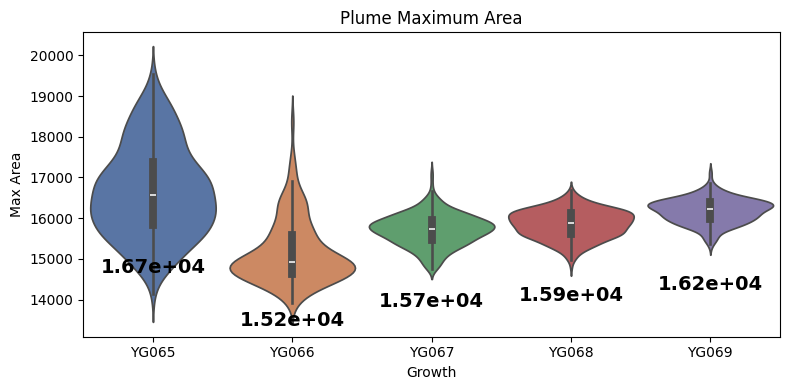

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.violinplot(x='Growth', y='Max Area', data=df_plume_metrics_target, width=0.9, ax=ax, palette='deep')
mean_max_area = df_plume_metrics_target.groupby('Growth')['Max Area'].mean()
label_violinplot(ax, mean_max_area, label_type='average_value', text_pos='center', value_format='scientific',
                 offset_parms={'x_type': 'fixed', 'x_value': 0, 'y_type': 'ratio', 'y_value': -0.12})
ax.set_title('Plume Maximum Area')
plt.tight_layout()
plt.show()

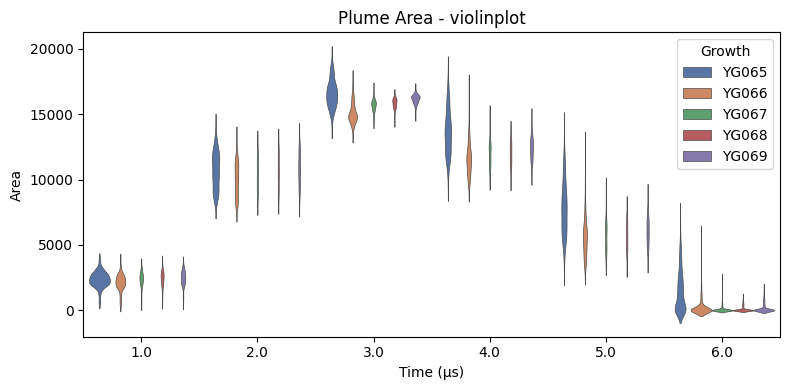

In [9]:
df_filtered = df_frame_metrics_target[df_frame_metrics_target['Time (µs)'].isin(range(1, 7))]
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.violinplot(x='Time (µs)', y='Area', hue='Growth', data=df_filtered, inner=None, width=0.9, linewidth=0.5, palette='deep')
ax.set_title('Plume Area - violinplot')
plt.tight_layout()
plt.show()

#### incident velocity

C:\Users\yig319\AppData\Local\Temp\ipykernel_42508\2688977855.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Growth', y='incident_velocity', data=df_plume_metrics_target, width=0.9, ax=ax, palette='deep')


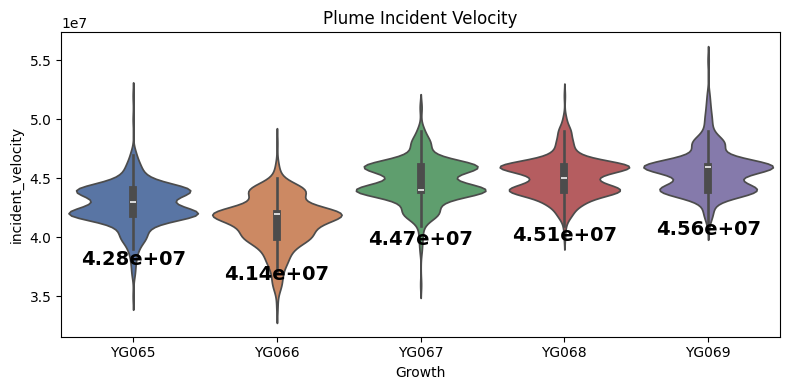

In [10]:
df_plume_metrics_target = df_plume_metrics[df_plume_metrics['Growth'].isin(growth_names)]
colors = sns.color_palette("viridis", as_cmap=False, n_colors=df_plume_metrics_target['Growth'].nunique())

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.violinplot(x='Growth', y='incident_velocity', data=df_plume_metrics_target, width=0.9, ax=ax, palette='deep')
mean_incident_velocity = df_plume_metrics_target.groupby('Growth')['incident_velocity'].mean()
label_violinplot(ax, mean_incident_velocity, label_type='average_value', text_pos='center', value_format='scientific', 
                 offset_parms={'x_type': 'fixed', 'x_value': 0, 'y_type': 'ratio', 'y_value': -0.12})
ax.set_title('Plume Incident Velocity')
plt.tight_layout()
plt.show()

##### why there are two peaks

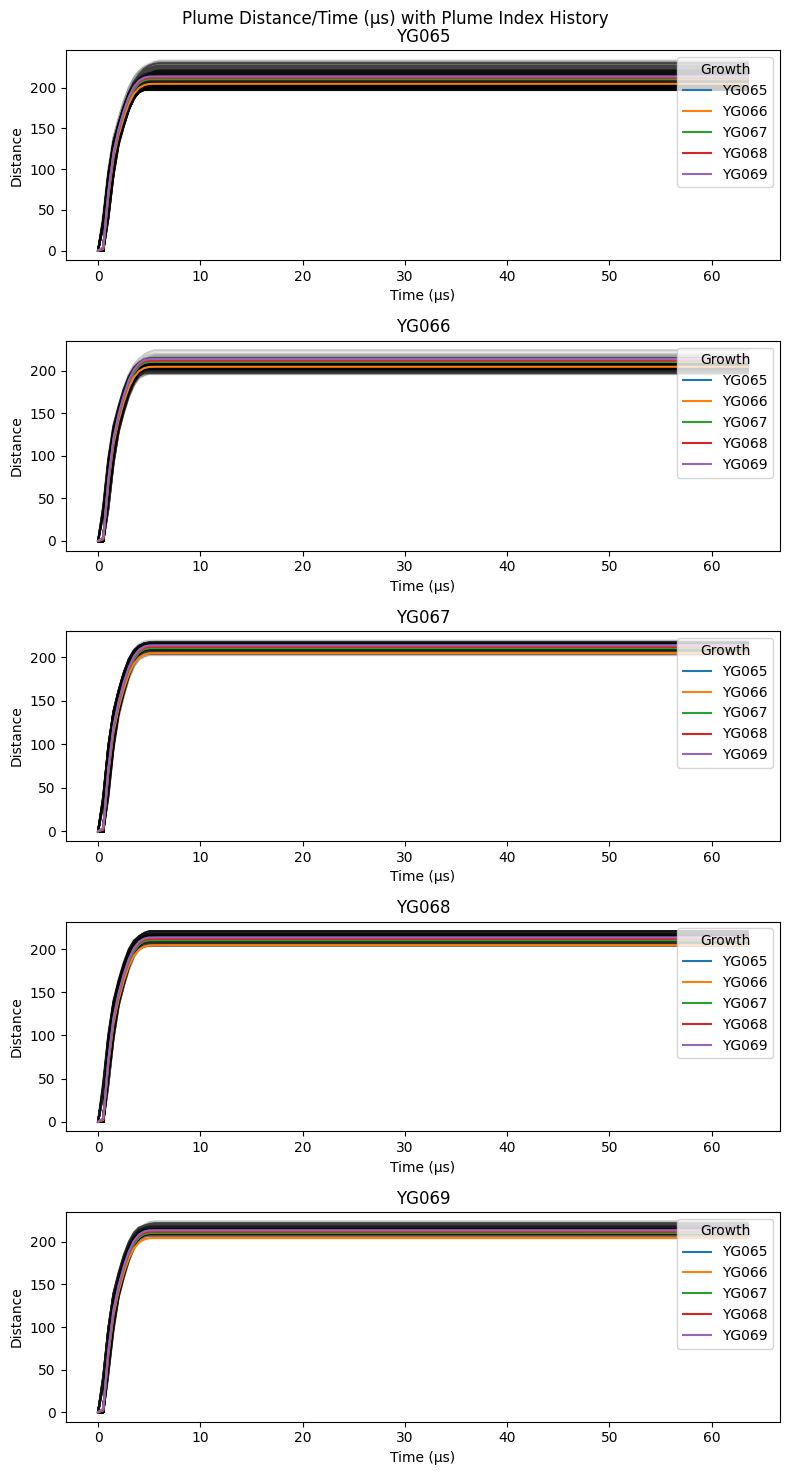

In [37]:
df_sample = df_frame_metrics_target
x_label, y_label = 'Time (µs)', 'Distance'

fig, axes = plt.subplots(5, 1, figsize=(8, 3*5))
for ax, growth in zip(axes, growth_names):
    
    # Create the first lineplot
    lineplot1 = sns.lineplot(x=x_label, y=y_label, hue="Plume Index", data=df_sample[df_sample['Growth'] == growth], ax=ax, palette='Greys')

    # Get the handles and labels specifically for the first plot (Plume Index)
    handles1, labels1 = lineplot1.get_legend().legend_handles, [t.get_text() for t in lineplot1.get_legend().get_texts()]
    legend1 = ax.legend(handles=handles1, labels=labels1, title="Plume Index", loc='upper left')
    # lineplot1.get_legend().remove()  # Remove the automatic legend

    # Create the second lineplot
    lineplot2 = sns.lineplot(x=x_label, y=y_label, hue="Growth", data=df_sample, ax=ax)

    # Manually filter out only the handles and labels corresponding to the second lineplot (Growth)
    legend2_handles, legend2_labels = [], []
    for handle, label in zip(lineplot2.get_legend().legend_handles, [t.get_text() for t in lineplot2.get_legend().get_texts()]):
        if label not in labels1:  # Only add labels not already in the first legend
            legend2_handles.append(handle)
            legend2_labels.append(label)

    legend2 = ax.legend(handles=legend2_handles, labels=legend2_labels, title="Growth", loc='upper right')
    lineplot2.get_legend().remove()  # Remove the automatic legend

    # Add the first legend back
    # ax.add_artist(legend1)
    ax.add_artist(legend2)

    ax.set_title(growth)
    # ax.set_xlim(0, 15)
plt.suptitle(f"Plume {y_label}/{x_label} with Plume Index History")
plt.tight_layout()
plt.show()

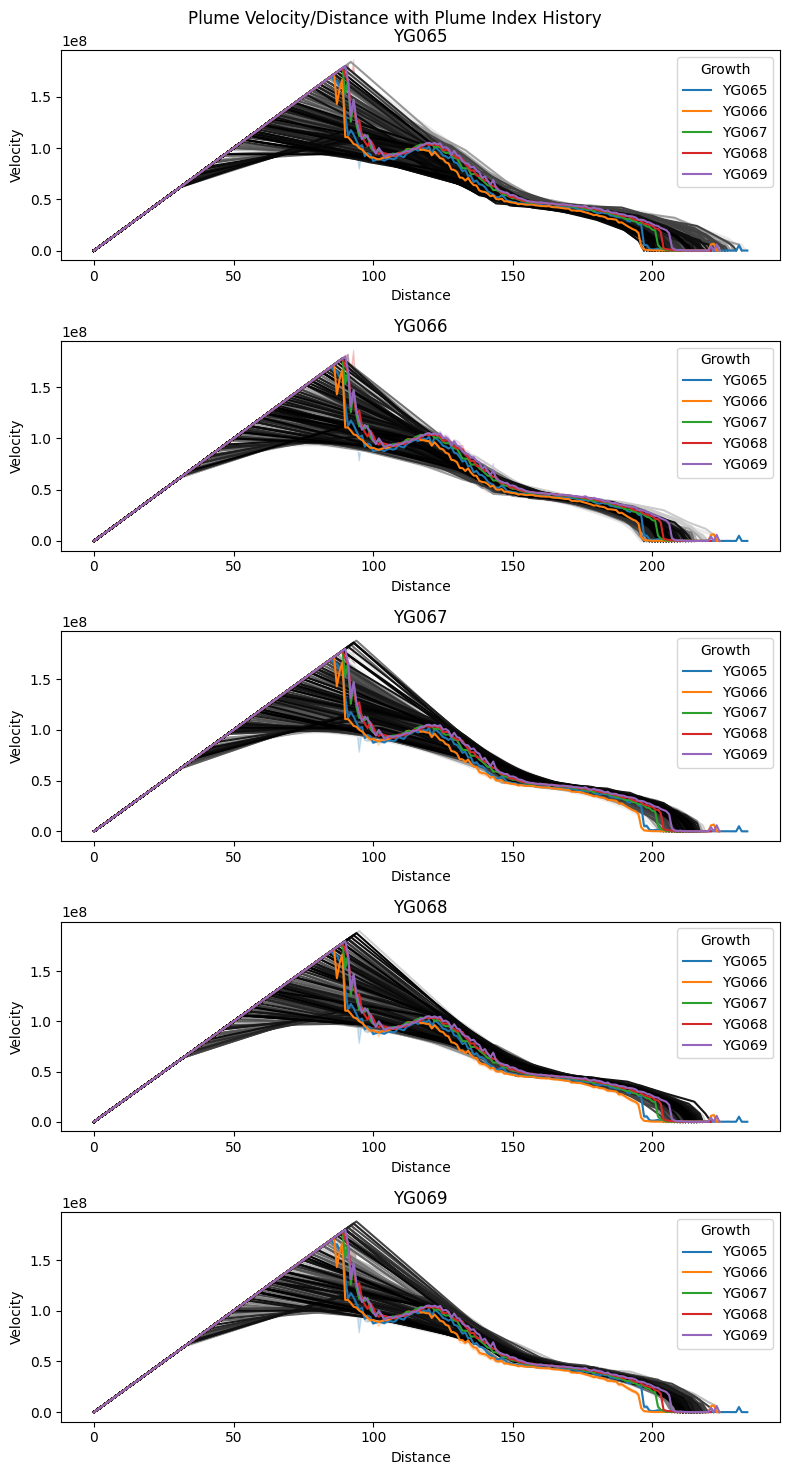

In [36]:
df_sample = df_frame_metrics_target
x_label, y_label = 'Distance', 'Velocity'

fig, axes = plt.subplots(5, 1, figsize=(8, 3*5))
for ax, growth in zip(axes, growth_names):
    
    # Create the first lineplot
    lineplot1 = sns.lineplot(x=x_label, y=y_label, hue="Plume Index", data=df_sample[df_sample['Growth'] == growth], ax=ax, palette='Greys')

    # Get the handles and labels specifically for the first plot (Plume Index)
    handles1, labels1 = lineplot1.get_legend().legend_handles, [t.get_text() for t in lineplot1.get_legend().get_texts()]
    legend1 = ax.legend(handles=handles1, labels=labels1, title="Plume Index", loc='upper left')
    # lineplot1.get_legend().remove()  # Remove the automatic legend

    # Create the second lineplot
    lineplot2 = sns.lineplot(x=x_label, y=y_label, hue="Growth", data=df_sample, ax=ax)

    # Manually filter out only the handles and labels corresponding to the second lineplot (Growth)
    legend2_handles, legend2_labels = [], []
    for handle, label in zip(lineplot2.get_legend().legend_handles, [t.get_text() for t in lineplot2.get_legend().get_texts()]):
        if label not in labels1:  # Only add labels not already in the first legend
            legend2_handles.append(handle)
            legend2_labels.append(label)

    legend2 = ax.legend(handles=legend2_handles, labels=legend2_labels, title="Growth", loc='upper right')
    lineplot2.get_legend().remove()  # Remove the automatic legend

    # Add the first legend back
    # ax.add_artist(legend1)
    ax.add_artist(legend2)

    ax.set_title(growth)
    # ax.set_xlim(0, 15)
plt.suptitle(f"Plume {y_label}/{x_label} with Plume Index History")
plt.tight_layout()
plt.show()

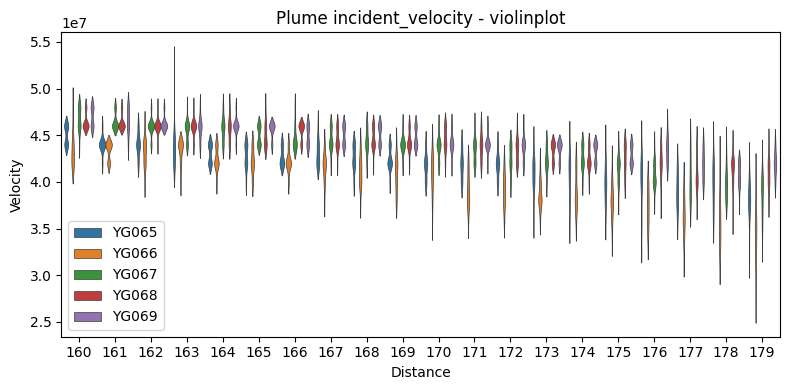

In [194]:
df_filtered = df_frame_metrics_target[df_frame_metrics_target['Distance'].isin(range(160, 180))]

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.violinplot(x='Distance', y='Velocity', hue='Growth', data=df_filtered, inner=None, width=0.9, linewidth=0.5)
ax.set_title('Plume incident_velocity - violinplot')
plt.legend(loc='lower left')  # Change the location and title of the legend
plt.tight_layout()
plt.show()

### frame level visualization

In [165]:
df_frame_metrics_target = df_frame_metrics[df_frame_metrics['Growth'].isin(['YG065', 'YG066', 'YG067', 'YG068', 'YG069'])]

# hue_label = 'Growth'
# palette_area = [(31, 119, 180), (44, 160, 44), (214, 39, 40)] 
# palette_area = [(r/255, g/255, b/255) for r, g, b in palette_area]
# palette_velocity = [(174, 199, 232), (152, 223, 138), (255, 152, 150)]
# palette_velocity = [(r/255, g/255, b/255) for r, g, b in palette_velocity]

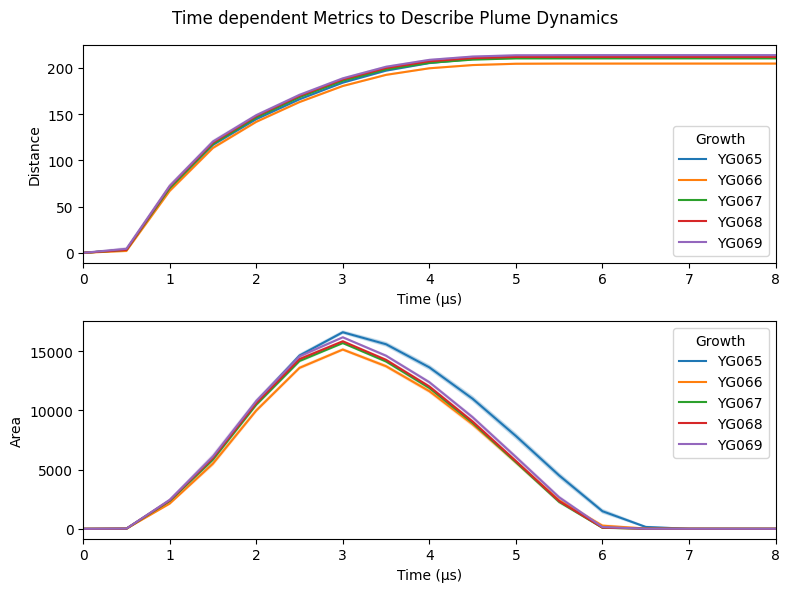

In [195]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
lineplot = sns.lineplot(x="Time (µs)", y="Distance", hue='Growth', data=df_frame_metrics_target, ax=axes[0])
axes[0].set_xlim(0, 8)

lineplot = sns.lineplot(x="Time (µs)", y="Area", hue='Growth', data=df_frame_metrics_target, ax=axes[1])
axes[1].set_xlim(0, 8)

plt.suptitle('Time dependent Metrics to Describe Plume Dynamics')
plt.tight_layout()
plt.show()

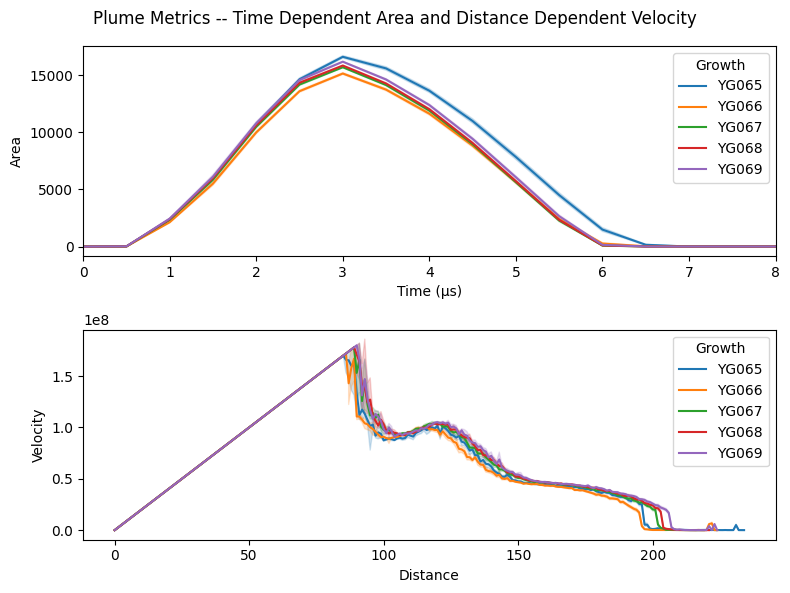

In [167]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
lineplot = sns.lineplot(x="Time (µs)", y="Area", hue='Growth', data=df_frame_metrics_target, ax=axes[0])
axes[0].set_xlim(0, 8)

lineplot = sns.lineplot(x="Distance", y="Velocity", hue='Growth', data=df_frame_metrics_target, ax=axes[1])

plt.suptitle('Plume Metrics -- Time Dependent Area and Distance Dependent Velocity')
plt.tight_layout()
plt.show()

In [122]:
# fig, axes = plt.subplots(2, 1, figsize=(8, 6))
# lineplot = sns.lineplot(x="Time (µs)", y="Distance", hue='Growth', data=df_frame_metrics_target, ax=axes[0])
# axes[0].set_xlim(0, 8)

# lineplot = sns.lineplot(x="Time (µs)", y="Velocity", hue='Growth', data=df_frame_metrics_target, ax=axes[1])
# axes[1].set_xlim(0, 8)

# plt.suptitle('Time dependent Metrics to Describe Plume Dynamics')
# plt.tight_layout()
# plt.show()

#### seperate view

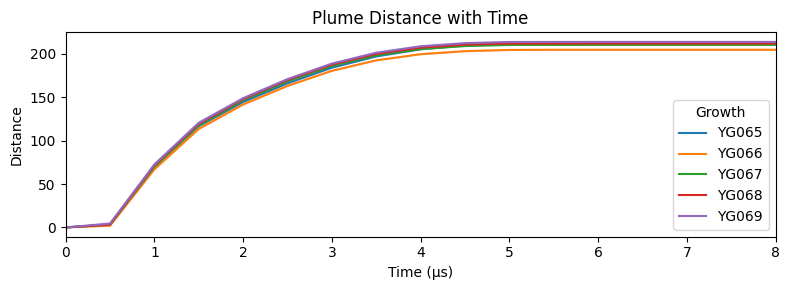

In [168]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
lineplot = sns.lineplot(x="Time (µs)", y="Distance", hue='Growth', data=df_frame_metrics_target, ax=ax)
ax.set_xlim(0, 8)
plt.title('Plume Distance with Time')
plt.tight_layout()
plt.show()

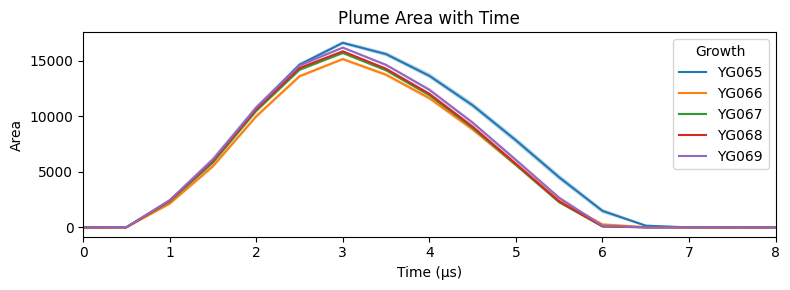

In [169]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
lineplot = sns.lineplot(x="Time (µs)", y="Area", hue='Growth', data=df_frame_metrics_target, ax=ax)
ax.set_xlim(0, 8)
plt.title('Plume Area with Time')
plt.tight_layout()
plt.show()

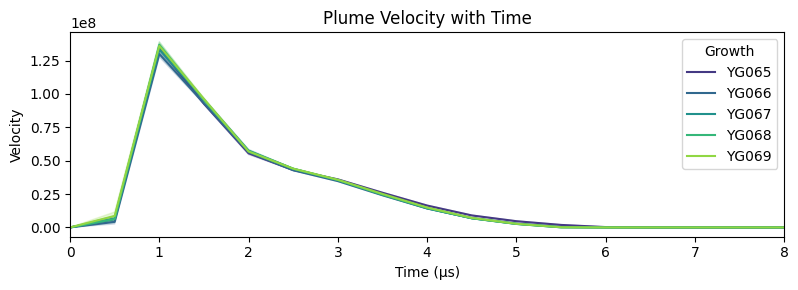

In [170]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
lineplot = sns.lineplot(x="Time (µs)", y="Velocity", hue='Growth', data=df_frame_metrics_target, ax=ax, palette=colors)
ax.set_xlim(0, 8)
plt.title('Plume Velocity with Time')
plt.tight_layout()
plt.show()

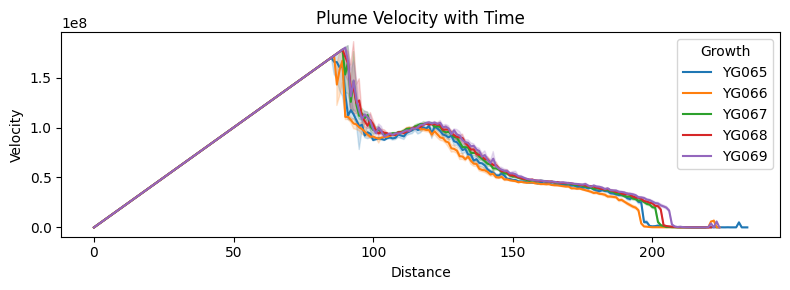

In [171]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
lineplot = sns.lineplot(x="Distance", y="Velocity", hue='Growth', data=df_frame_metrics_target, ax=ax)
plt.title('Plume Velocity with Time')
plt.tight_layout()
plt.show()

### peridocity heatmap

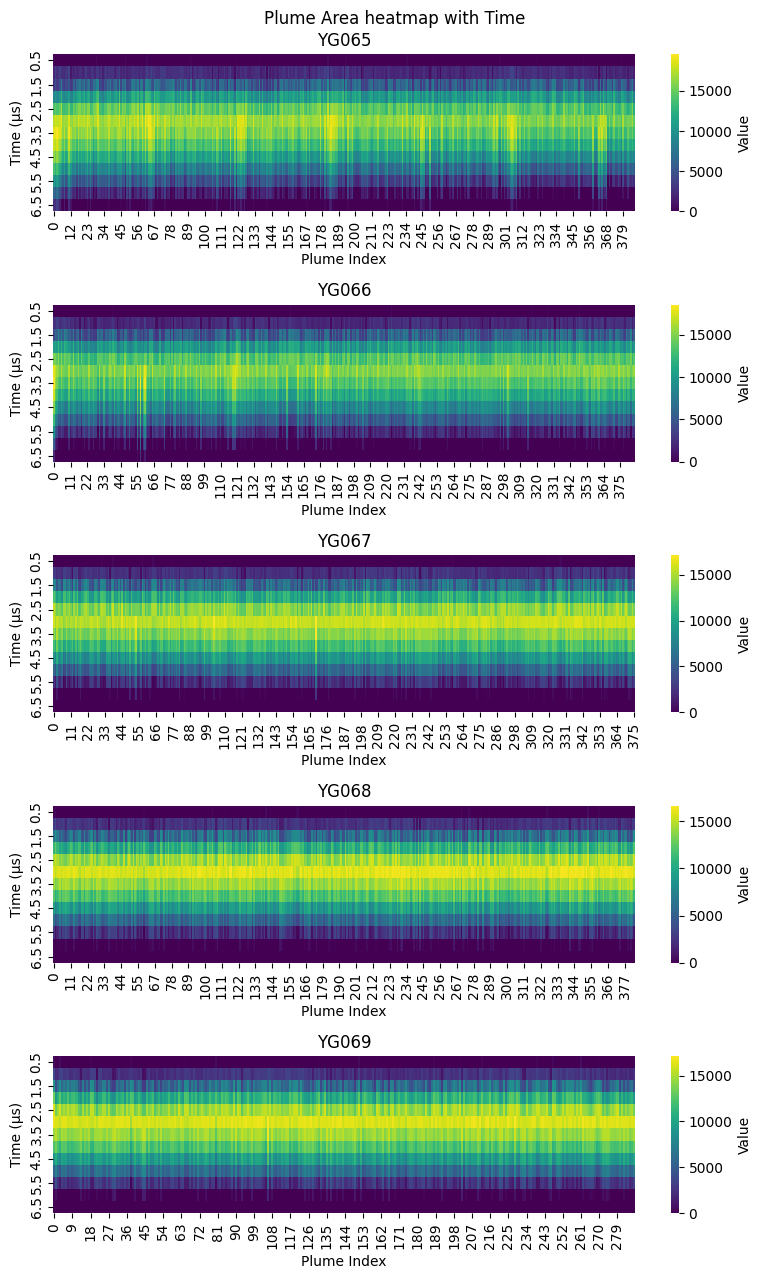

In [45]:
df_sample = df_frame_metrics_target[(df_frame_metrics_target['Time (µs)'] >= 0.5) & (df_frame_metrics_target['Time (µs)'] < 7)] 

fig, axes = plt.subplots(5, 1, figsize=(8, 4*3+1))
for ax, growth in zip(axes, growth_names):
    df_pivot = df_sample[df_sample['Growth']==growth].pivot(index="Time (µs)", columns="Plume Index", values="Area")
    sns.heatmap(df_pivot, cmap='viridis', cbar_kws={'label': 'Value'}, ax=ax)
    ax.set_xlabel("Plume Index")
    ax.set_ylabel("Time (µs)")
    ax.set_title(growth)
plt.suptitle("Plume Area heatmap with Time")
plt.tight_layout()
plt.show()

### time history of plume area

In [139]:
colors = sns.color_palette("viridis", as_cmap=False, n_colors=df_plume_metrics_target['Growth'].nunique()) # viridis
# colors = ['#4A5E65', '#E29957', '#B95A58', '#4292C6', '#86B5A1']

In [140]:
import numpy as np
import matplotlib.colors as mcolors

def generate_gradient(color_hex, steps):
    # Convert hex to RGB and ensure it is a NumPy array
    color_rgb = np.array(mcolors.hex2color(color_hex))
    white_rgb = np.array([1, 1, 1])  # White color as RGB
    # Generate gradient and convert each step back to hex
    gradient = [mcolors.rgb2hex(color_rgb * (1 - i / steps) + white_rgb * (i / steps)) for i in range(steps)]
    return gradient

custom_palette = generate_gradient("#4A5E65", 10)  # Generate 10 steps of blue to white gradient

C:\Users\yig319\AppData\Local\Temp\ipykernel_42508\2162508357.py:10: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles1, labels1 = lineplot1.get_legend().legendHandles, [t.get_text() for t in lineplot1.get_legend().get_texts()]
C:\Users\yig319\AppData\Local\Temp\ipykernel_42508\2162508357.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles2, labels2 = lineplot2.get_legend().legendHandles, [t.get_text() for t in lineplot2.get_legend().get_texts()]
C:\Users\yig319\AppData\Local\Temp\ipykernel_42508\2162508357.py:10: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles1, labels1 = lineplot1.get_legend().legendHandles, 

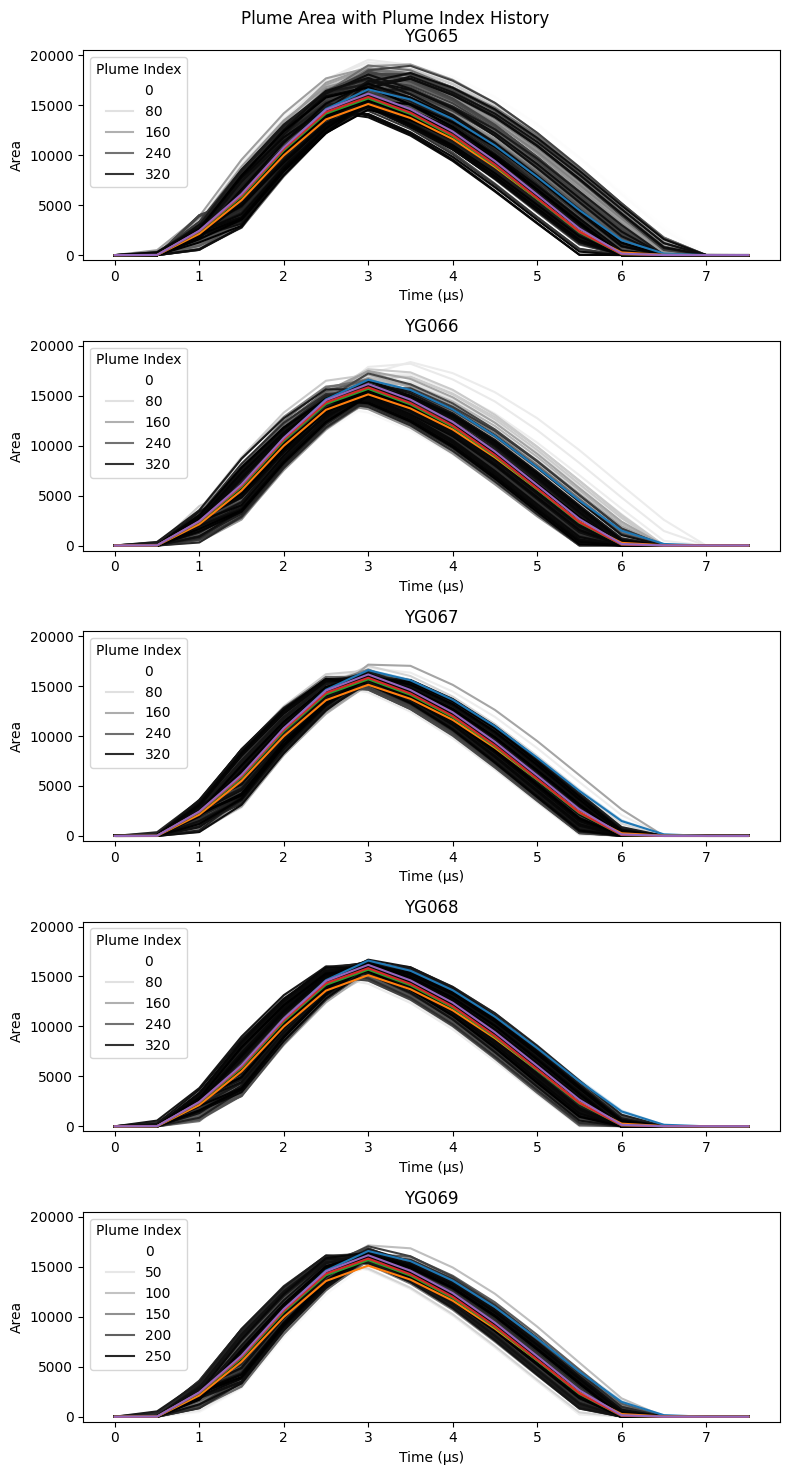

In [29]:
df_sample = df_frame_metrics_target[(df_frame_metrics_target['Time (µs)'] >= 0) & (df_frame_metrics_target['Time (µs)'] < 8)] 

fig, axes = plt.subplots(5, 1, figsize=(8, 3*5))
for ax, growth in zip(axes, growth_names):
    
    # Create the first lineplot
    lineplot1 = sns.lineplot(x="Time (µs)", y="Area", hue="Plume Index", data=df_sample[df_sample['Growth'] == growth], ax=ax, palette='Greys')

    # Get the handles and labels specifically for the first plot (Plume Index)
    handles1, labels1 = lineplot1.get_legend().legendHandles, [t.get_text() for t in lineplot1.get_legend().get_texts()]
    legend1 = ax.legend(handles=handles1, labels=labels1, title="Plume Index", loc='upper left')
    lineplot1.get_legend().remove()  # Remove the automatic legend

    # Create the second lineplot
    lineplot2 = sns.lineplot(x="Time (µs)", y="Area", hue="Growth", data=df_sample, ax=ax)

    # Get the handles and labels specifically for the second plot (Growth)
    handles2, labels2 = lineplot2.get_legend().legendHandles, [t.get_text() for t in lineplot2.get_legend().get_texts()]
    legend2 = ax.legend(handles=handles2, labels=labels2, title="Growth", loc='upper right')
    lineplot2.get_legend().remove()  # Remove the automatic legend

    # Add the first legend back after the second one has been added
    ax.add_artist(legend1)

    ax.set_title(growth)
    # ax.set_xlim(0, 15)
    ax.set_ylim(-500, 20500)
plt.suptitle("Plume Area with Plume Index History")
plt.tight_layout()
plt.show()